# ¿Comprar casa o Alquilar? Naive Bayes  


##### En clasificación bayesiana estamos interesados en encontrar la probabilidad de que ocurra una «clase» dadas unas características observadas (datos). Lo podemos escribir como P( Clase | Datos). El teorema de Bayes nos dice cómo lo podemos expresar en términos de cantidades que podemos calcular directamente:

In [23]:
#Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

In [7]:
#Cargamos el archivo y leemos algunos 
dataframe = pd.read_csv("comprar_alquilar.csv")
dataframe.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


### Las columnas que tenemos son:
ingresos:los ingresos de la familia mensual

gastos comunes: pagos de luz, agua, gas, etc mensual

pago coche: si se está pagando cuota por uno o más coches, y los gastos en combustible, etc al mes.

gastos_otros: compra en supermercado y lo necesario para vivir al mes

ahorros: suma de ahorros dispuestos a usar para la compra de la casa.

vivienda: precio de la vivienda que quiere comprar esa familia

estado civil:

    0-soltero

    1-casados

    2-divorciados

hijos: cantidad de hijos menores y que no trabajan.

trabajo:

    0-sin empleo 
    1-autónomo (freelance)
    2-empleado
    3-empresario
    4-pareja: autónomos
    5-pareja: empleados
    6-pareja: autónomo y asalariado
    7-pareja:empresario y autónomo
    8-pareja: empresarios los dos o empresario y empleado

comprar: 

    0-No comprar 
    1-Comprar (esta será nuestra columna de salida, para aprender)


#### Con esta información, queremos que el algoritmo aprenda y que como resultado podamos consultar nueva información y nos dé una decisión sobre comprar (1) o alquilar (0) casa.

## El teorema de Bayes
 En clasificación bayesiana estamos interesados en encontrar la probabilidad de que ocurra una **«clase»** dadas unas características observadas (datos). Lo podemos escribir como **P( Clase | Datos)**. El teorema de Bayes nos dice cómo lo podemos expresar en términos de cantidades que podemos calcular directamente:
 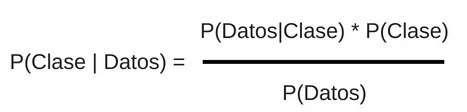
 
**Clase** es una salida en particular, por ejemplo «comprar»

**Datos** son nuestras características, en nuestro caso los ingresos, gastos, hijos, etc

**P(Clase|Datos)** se llama posterior (y es el resultado que queremos hallar)

**P(Datos|Clase)** se llama «verosimilitud» 

**P(Clase)** se llama anterior (pues es una probabilidad que ya tenemos)

**P(Datos)** se llama probabilidad marginal
 
### Si estamos tratando de elegir entre dos clases como en nuestro caso «comprar» ó «alquilar», entonces una manera de tomar la decisión es calcular la tasa de probabilidades:

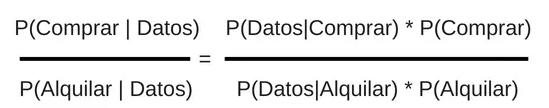

# Clasificador Gaussian Naive Bayes
Uno de los tipos de clasificadores más populares es el llamado en inglés Gaussian Naive Bayes Classifier.Este nos dice que sobre una variable dependiente **C**, con un pequeño número de resultados (o clases). Esta variable está condicionada por varias variables independientes desde **F_1** a **F_n**. Para comprender este curioso nombre: aplicaremos 2 clases (comprar, alquilar) y tres características: ingresos, ahorros e hijos.

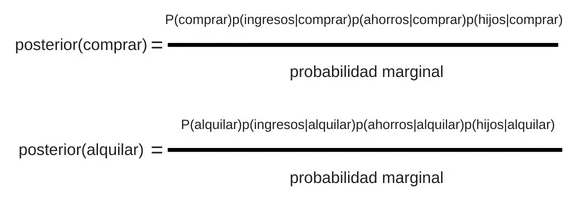

### Lo que queremos hallar: P(comprar|datos).

## Visualización de Datos
**Veamos qué cantidad de muestras de comprar(1) o alquilar(0) tenemos:**

In [8]:
print(dataframe.groupby('comprar').size())

comprar
0    135
1     67
dtype: int64


In [10]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1).head(10)

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,50000,400000,0,2,2,1,1600,350000
1,6745,43240,636897,1,3,6,0,1496,593657
2,6455,57463,321779,2,1,8,1,1926,264316
3,7098,54506,660933,0,0,3,0,1547,606427
4,6167,41512,348932,0,0,3,1,1606,307420
5,5692,50875,360863,1,4,5,1,1247,309988
6,6830,46761,429812,1,1,5,1,1952,383051
7,6470,57439,606291,0,0,1,0,1856,548852
8,6251,50503,291010,0,0,3,1,2030,240507
9,6987,40611,324098,2,1,7,1,1755,283487


## Preparar los datos de entrada
#### Vamos a agrupar los diversos gastos y a crear una columna llamada financiar que será la resta  del precio de la vivienda con los ahorros de la familia.

In [24]:

reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1)
reduced.describe()

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


## Selección de Características

#### En vez de utilizar las 11 columnas de datos de entrada que tenemos, vamos a utilizar una Clase de SkLearn llamada SelectKBest con la que seleccionaremos las 5 mejores características y usaremos sólo esas.

In [12]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']
 
best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar'], dtype='object')


#### Usaremos 5 de las 11 características que teníamos. Las que más aportan al momento de clasificar y veremos qué grado de correlación tienen:

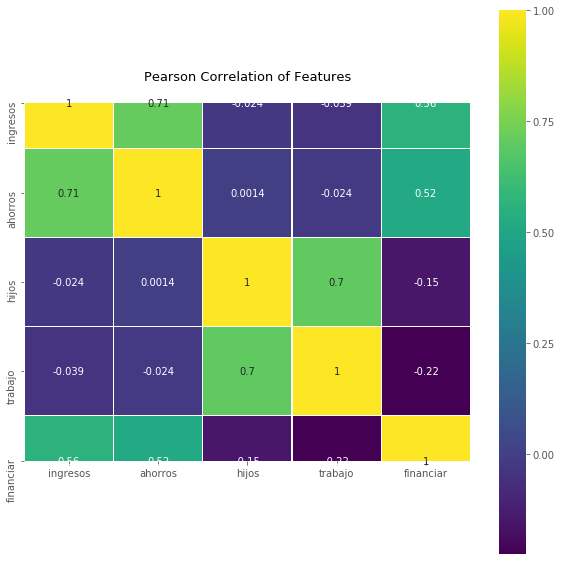

In [33]:
used_features =X.columns[selected]
 
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=13)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

#### Con esto comprobamos que en general están poco correlacionadas, sin embargo también tenemos 2 valores de 0,7. 

In [18]:
# Split dataset in training and test datasets
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=6) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]

## Crear el modelo Gaussian Naive Bayes con SKLearn

In [19]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])
 
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test)))

Precisión en el set de Entrenamiento: 0.87
Precisión en el set de Test: 0.90


#### Primero vamos a dividir nuestros datos de entrada en entrenamiento y test.

In [ ]:
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=6) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]

In [ ]:
#### Creamos el modelo y lo entenamos con fit() para obtener predicciones sobre nuestro conjunto de test.

In [ ]:
#Creamos el clasificador
gnb = GaussianNB()
#Entrenamos el clasificador
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])
 
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test)))

#### Se ve que obtuvimos un 90% de aciertos en el conjunto de Test con  el clasificador bayesiano.

# Probemos el modelo: ¿Comprar o Alquilar?

* En un caso será una familia sin hijos con 2.000 de ingresos que quiere comprar una casa de 200.000 y tiene sólo 5.000 ahorrados.

* El otro será una familia con 2 hijos con ingresos por 6.000 al mes, 34.000 en ahorros y consultan si comprar una casa de 320.000.

In [20]:
#                 ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[2000,        5000,     0,       5,         200000],
                   [6000,        34000,    2,       5,         320000] ]))
#Resultado esperado 0-Alquilar, 1-Comprar casa

[0 1]


Los resultados son los esperados, en el primer caso, recomienda Alquilar (0) y en el segundo comprar la casa (1).